In [23]:
from Features.birds import *
from Features.sweden_map import *
from Features.weather import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


In [2]:
golden = API_bird_data(bird_type="goleag")
#white = API_bird_data(bird_type="whteag")



Bird data API response code: 200


In [3]:
print(golden)

[{'speciesCode': 'goleag', 'comName': 'Golden Eagle', 'sciName': 'Aquila chrysaetos', 'locId': 'L53102821', 'locName': 'Myrse yard', 'obsDt': '2025-11-29 11:50', 'howMany': 1, 'lat': 57.5359277, 'lng': 18.2807413, 'obsValid': True, 'obsReviewed': False, 'locationPrivate': True, 'subId': 'S286591513'}]


In [4]:
#print(white[0])
lat = 57.7358823
lng = 13.4065944

In [5]:
map=SwedenMap()

print(map.point_to_region(lat, lng))

Gotland


In [6]:
map.middle_point_of_region("Gotland")

(57.51723947372926, 18.538432396771)

In [7]:
API_tomorrow_weather(lon=lng, lat=lat, days=7)

{'latitude': 57.732597,
 'longitude': 13.398376,
 'generationtime_ms': 0.34165382385253906,
 'utc_offset_seconds': 3600,
 'timezone': 'Europe/Berlin',
 'timezone_abbreviation': 'GMT+1',
 'elevation': 165.0,
 'daily_units': {'time': 'iso8601',
  'temperature_2m_mean': '°C',
  'precipitation_sum': 'mm',
  'weather_code': 'wmo code',
  'wind_speed_10m_mean': 'km/h'},
 'daily': {'time': ['2025-12-12',
   '2025-12-13',
   '2025-12-14',
   '2025-12-15',
   '2025-12-16',
   '2025-12-17',
   '2025-12-18'],
  'temperature_2m_mean': [7.0, 4.8, 6.4, 5.8, 4.3, 3.8, 5.3],
  'precipitation_sum': [0.0, 3.7, 5.1, 3.3, 0.0, 0.0, 1.6],
  'weather_code': [3, 55, 55, 53, 3, 3, 51],
  'wind_speed_10m_mean': [7.2, 8.8, 17.9, 19.0, 14.8, 10.7, 15.7]}}

In [8]:
historical_weather_download(start_date="2025-12-01", lon=lng, lat=lat)

({'latitude': 57.75044,
  'longitude': 13.218143,
  'generationtime_ms': 13.6643648147583,
  'utc_offset_seconds': 3600,
  'timezone': 'Europe/Berlin',
  'timezone_abbreviation': 'GMT+1',
  'elevation': 165.0,
  'daily_units': {'time': 'iso8601',
   'temperature_2m_mean': '°C',
   'precipitation_sum': 'mm',
   'wind_speed_10m_mean': 'km/h',
   'weather_code': 'wmo code'},
  'daily': {'time': ['2025-12-01',
    '2025-12-02',
    '2025-12-03',
    '2025-12-04',
    '2025-12-05',
    '2025-12-06',
    '2025-12-07',
    '2025-12-08',
    '2025-12-09',
    '2025-12-10',
    '2025-12-11',
    '2025-12-12'],
   'temperature_2m_mean': [4.5,
    3.9,
    3.0,
    3.4,
    3.1,
    3.6,
    4.1,
    6.4,
    6.6,
    7.9,
    7.3,
    6.8],
   'precipitation_sum': [1.0,
    1.6,
    1.1,
    2.0,
    1.6,
    2.3,
    1.9,
    18.4,
    3.7,
    10.2,
    4.7,
    0.2],
   'wind_speed_10m_mean': [20.7,
    20.1,
    10.6,
    10.8,
    10.4,
    9.7,
    12.8,
    22.5,
    15.9,
    19.7,
    2

## Bird data

What we want: 
lat, lon, num obs, time (maybe), obsReviewed

from api:


In [9]:
df_golden = pd.read_csv(
    'Data/ebd_SE_goleag_smp_relOct-2025_extracted/ebd_SE_goleag_smp_relOct-2025.txt', 
    sep='\t', 
    low_memory=False, # Prevents DtypeWarnings on mixed-type columns in large files
    parse_dates=['OBSERVATION DATE', 'LAST EDITED DATE'] # Optional: converts dates immediately
)

df_whteag = pd.read_csv(
    "Data/ebd_SE_whteag_smp_relOct-2025_extracted/ebd_SE_whteag_smp_relOct-2025.txt",
    sep='\t', 
    low_memory=False, # Prevents DtypeWarnings on mixed-type columns in large files
    parse_dates=['OBSERVATION DATE', 'LAST EDITED DATE'] # Optional: converts dates immediately
)

print(df_golden.shape)
print(df_whteag.shape)

(2237, 53)
(26558, 53)


In [10]:
df_whteag.head()

,GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,TAXON CONCEPT ID,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,EXOTIC CODE,...,NUMBER OBSERVERS,ALL SPECIES REPORTED,GROUP IDENTIFIER,HAS MEDIA,APPROVED,REVIEWED,REASON,CHECKLIST COMMENTS,SPECIES COMMENTS,Unnamed: 52
0,URN:CornellLabOfOrnithology:EBIRD:OBS905261802,2021-03-31 05:24:58.010892,8364,species,avibase-5A3D91D3,White-tailed Eagle,Haliaeetus albicilla,NaN,NaN,NaN,...,NaN,0,NaN,0,1,0,NaN,NaN,<b>First Sighting:</b> X (Auto)<br>,NaN
1,URN:CornellLabOfOrnithology:EBIRD:OBS1502041040,2024-09-24 03:31:27.021565,8364,species,avibase-5A3D91D3,White-tailed Eagle,Haliaeetus albicilla,NaN,NaN,NaN,...,2.0,1,NaN,0,1,0,NaN,NaN,NaN,NaN
2,URN:CornellLabOfOrnithology:EBIRD:OBS1580291533,2025-10-13 00:06:22.414185,8364,species,avibase-5A3D91D3,White-tailed Eagle,Haliaeetus albicilla,NaN,NaN,NaN,...,4.0,1,NaN,0,1,0,NaN,NaN,NaN,NaN
3,URN:CornellLabOfOrnithology:EBIRD:OBS1587626445,2024-09-24 06:21:46.888353,8364,species,avibase-5A3D91D3,White-tailed Eagle,Haliaeetus albicilla,NaN,NaN,NaN,...,2.0,1,NaN,0,1,0,NaN,NaN,NaN,NaN
4,URN:CornellLabOfOrnithology:EBIRD:OBS1622002250,2024-10-17 22:00:16.283789,8364,species,avibase-5A3D91D3,White-tailed Eagle,Haliaeetus albicilla,NaN,NaN,NaN,...,3.0,1,NaN,0,1,0,NaN,NaN,NaN,NaN


In [11]:
df_whteag.columns

Index(['GLOBAL UNIQUE IDENTIFIER', 'LAST EDITED DATE', 'TAXONOMIC ORDER',
       'CATEGORY', 'TAXON CONCEPT ID', 'COMMON NAME', 'SCIENTIFIC NAME',
       'SUBSPECIES COMMON NAME', 'SUBSPECIES SCIENTIFIC NAME', 'EXOTIC CODE',
       'OBSERVATION COUNT', 'BREEDING CODE', 'BREEDING CATEGORY',
       'BEHAVIOR CODE', 'AGE/SEX', 'COUNTRY', 'COUNTRY CODE', 'STATE',
       'STATE CODE', 'COUNTY', 'COUNTY CODE', 'IBA CODE', 'BCR CODE',
       'USFWS CODE', 'ATLAS BLOCK', 'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE',
       'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
       'TIME OBSERVATIONS STARTED', 'OBSERVER ID', 'OBSERVER ORCID ID',
       'SAMPLING EVENT IDENTIFIER', 'OBSERVATION TYPE', 'PROTOCOL NAME',
       'PROTOCOL CODE', 'PROJECT NAMES', 'PROJECT IDENTIFIERS',
       'DURATION MINUTES', 'EFFORT DISTANCE KM', 'EFFORT AREA HA',
       'NUMBER OBSERVERS', 'ALL SPECIES REPORTED', 'GROUP IDENTIFIER',
       'HAS MEDIA', 'APPROVED', 'REVIEWED', 'REASON', 'CHECKLIST COMMENTS',
       'SPECI

In [ ]:
#1
def drop_unused_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols_keep = ["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"]

    return df[cols_keep]

def fill_na_times(df: pd.DataFrame) -> pd.DataFrame:
    times = pd.to_datetime(df['TIME OBSERVATIONS STARTED'], format='%H:%M:%S', errors='coerce')

    # Calculate mean, round to nearest Hour ('H'), extract time
    mean_time = times.mean().round('h').time()
    df = df.fillna({"TIME OBSERVATIONS STARTED": mean_time})
    return df

def sort_bird_df_date_time(df:pd.DataFrame) -> pd.DataFrame:
    #df['TIME OBSERVATIONS STARTED'] = pd.to_datetime(df['TIME OBSERVATIONS STARTED'], format='%H:%M:%S', errors='coerce')
    df.sort_values(by=['OBSERVATION DATE', 'TIME OBSERVATIONS STARTED'], inplace=True)
    return df

def filter_by_year(df: pd.DataFrame, year: int = 2004) -> pd.DataFrame:
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])
    return df[df['OBSERVATION DATE'].dt.year >= year]

def merge_bird_with_daily(bird_df: pd.DataFrame, today:str, b_type:str) -> pd.DataFrame:
    daily_dict=API_bird_data(bird_type=b_type)
    daily_df = pd.DataFrame(daily_dict)
   
    daily_df.rename(columns={"obsDt":"OBSERVATION DATE", "lat": "LATITUDE", "lng": "LONGITUDE", "howMany": "OBSERVATION COUNT"}, inplace=True)
    daily_df.drop(columns=["speciesCode","comName", "sciName", "locId", "locName", "obsValid", "obsReviewed", "locationPrivate", "subId"], inplace=True) # what is the howMany column
    
    daily_df['OBSERVATION DATE'] = pd.to_datetime(daily_df['OBSERVATION DATE']) # Convert to datetime
    daily_df['TIME OBSERVATIONS STARTED'] = daily_df['OBSERVATION DATE'].dt.strftime('%H:%M:%S') # Extract time as H-M-S
    daily_df['OBSERVATION DATE'] = daily_df['OBSERVATION DATE'].dt.strftime('%Y-%m-%d') # Keep only date string
    
    daily_df = daily_df[daily_df['OBSERVATION DATE'] == today]
    if daily_df.empty:
        print("No observations for today in daily data.")
        return bird_df
    
    merged_df = pd.concat([bird_df, daily_df], ignore_index=True)
    merged_df['OBSERVATION DATE'] = pd.to_datetime(merged_df['OBSERVATION DATE']).dt.strftime('%Y-%m-%d') # Ensure consistent date formatting
    return merged_df

def map_bird_region(df: pd.DataFrame) -> pd.DataFrame:
    map=SwedenMap()
    regions = []
    for index, row in df.iterrows():
        lat = row['LATITUDE']
        lng = row['LONGITUDE']
        region = map.point_to_region(lon=lng,lat=lat)
        regions.append(region)
    df['REGION'] = regions
    return df


def merge_weather_data(bird_df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    # 1. Pivot weather_df so variables (Temp, Rain, etc.) become columns
    # Assumes 'daily' column contains actual lists. If strings, use ast.literal_eval first.
    weather_pivoted = weather_df.pivot(index='REGION', columns='daily_units', values='daily')

    # 2. Explode the lists into individual rows (pandas >= 1.3.0)
    weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

    # 3. Rename columns to match requirements
    weather_exploded.rename(columns={
        'iso8601': 'OBSERVATION DATE',
        '°C': 'TEMPERATURE',
        'mm': 'RAIN',
        'km/h': 'WIND',
        'wmo code': 'WEATHERCODE'
    }, inplace=True)
    
    # 4. Reset index to turn REGION back into a column
    weather_exploded.reset_index(inplace=True)

    # 5. Ensure date formats match for merging
    bird_df['OBSERVATION DATE'] = bird_df['OBSERVATION DATE'].astype(str)
    weather_exploded['OBSERVATION DATE'] = weather_exploded['OBSERVATION DATE'].astype(str)

    # 6. Merge left to keep all bird observations
    merged_df = pd.merge(bird_df, weather_exploded, on=['REGION', 'OBSERVATION DATE'], how='left')

    return merged_df


def add_weather_to_bird(bird_df: pd.DataFrame) -> pd.DataFrame:
    map=SwedenMap()
    weather_df = pd.DataFrame()
    for key, (lat, lng) in map.centroid_dict.items():
        weather_dict, COLS = historical_weather_download(start_date="2025-12-01", lon=lng, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = key
        weather_df = pd.concat([weather_df, temp_weather_df], ignore_index=True)
    
    # we have COLS = ["OBSERVATION DATE", "TEMPERATURE", "RAIN", "WIND", "WEATHERCODE"]
    # from the dataframe, the daily col needs to be exploaded into separate columns with the same index
    
    merged_df = merge_weather_data(bird_df, weather_df)
    return merged_df

def add_normalized_year(df: pd.DataFrame, start_year: int = 2004) -> pd.DataFrame:
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])
    df['YEAR'] = df['OBSERVATION DATE'].dt.year - start_year
    return df


In [28]:
TODAY = datetime.now().strftime("%Y-%m-%d")
print("Today's date:", TODAY)
df_dropped = drop_unused_columns(df_whteag)
df_whteag_a = fill_na_times(df_dropped)
df_whteag_a2 = sort_bird_df_date_time(df_whteag_a)
print(df_whteag_a2.shape)
df_whteag_a2 = filter_by_year(df_whteag_a2, year=2004)
print(df_whteag_a2.shape)
merged_white = merge_bird_with_daily(df_whteag_a2, today="2025-12-11", b_type="whteag")
merged_white = map_bird_region(merged_white)


Today's date: 2025-12-12
(26558, 5)
(25727, 5)
Bird data API response code: 200


In [29]:
full_whatever = add_weather_to_bird(merged_white)


In [ ]:
full_w_year = add_normalized_year(full_whatever, start_year=2004)

full_w_day

,OBSERVATION COUNT,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,REGION,WIND,RAIN,WEATHERCODE,TEMPERATURE,YEAR,DAY
0,1,59.321393,18.022342,2004-01-01,11:00:00,Södermanland,NaN,NaN,NaN,NaN,0,0.008607
1,2,61.725860,17.105540,2004-01-01,11:00:00,Hälsingland,NaN,NaN,NaN,NaN,0,0.008607
2,1,56.681188,16.373339,2004-01-01,09:00:00,Småland,NaN,NaN,NaN,NaN,0,0.008607
3,2,58.746119,17.867889,2004-01-03,11:00:00,Södermanland,NaN,NaN,NaN,NaN,0,0.025818
4,1,55.556500,13.858400,2004-01-04,11:00:00,Skåne,NaN,NaN,NaN,NaN,0,0.034422
...,...,...,...,...,...,...,...,...,...,...,...,...
25723,2,56.195532,16.398811,2025-10-31,08:15:00,Öland,NaN,NaN,NaN,NaN,21,0.501242
25724,1,56.215919,12.779149,2025-10-31,09:30:00,Skåne,NaN,NaN,NaN,NaN,21,0.501242
25725,2,56.226853,12.746526,2025-10-31,10:20:00,Skåne,NaN,NaN,NaN,NaN,21,0.501242
25726,1,59.813048,16.162983,2025-10-31,13:11:00,Västmanland,NaN,NaN,NaN,NaN,21,0.501242


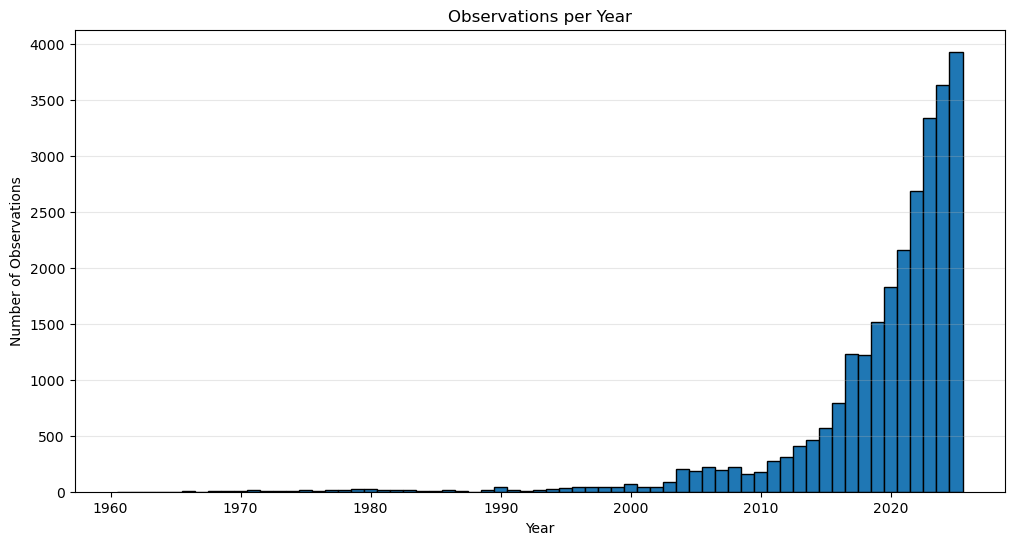

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure OBSERVATION DATE is datetime
full_whatever['OBSERVATION DATE'] = pd.to_datetime(full_whatever['OBSERVATION DATE'])

# Plot histogram
plt.figure(figsize=(12, 6))
years = full_whatever['OBSERVATION DATE'].dt.year
plt.hist(years, bins=range(years.min(), years.max() + 2), edgecolor='black', align='left')

plt.title('Observations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.grid(axis='y', alpha=0.3)
plt.savefig('observations_per_year.png')